# Simple quadratic convex problems

@Author: Ettore Biondi - ebiondi@caltech.edu

## Instantiation of vectors and operator
For testing the library we will be using a discretized version of the following operator:
\begin{align}
y = \frac{d^2f(x)}{dx^2},
\end{align}
in which we simply compute the second-order derivative of a function $f(x)$. 

#### Importing necessary libraries

In [1]:
import numpy as np
import occamypy as o

# Plotting
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
rcParams.update({
    'image.cmap'     : 'gray',
    'image.aspect'   : 'auto',
    'image.interpolation': None,
    'axes.grid'      : True,
    'figure.figsize' : (6, 4),
    'savefig.dpi'    : 300,
    'axes.labelsize' : 14,
    'axes.titlesize' : 16,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex'    : True,
    'font.family'    : 'serif',
    'font.serif'     : 'Latin Modern Roman',
})

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


/Users/francesco/miniconda3/envs/occd/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
N = 200  # Number of points of the function f(x)
dx = 1/N  # Sampling of the function

# The stencil used is simply: (f(ix-1)-2f(ix)+f(ix+1))/(dx*dx)
D2 = np.zeros((N, N), dtype=np.float64)
np.fill_diagonal(D2, -2 / (dx * dx))
np.fill_diagonal(D2[1:], 1 / (dx * dx))
np.fill_diagonal(D2[:,1:], 1 / (dx * dx))

f = o.VectorNumpy((N, 1)).zero()
y = f.clone()

D2 = o.Matrix(o.VectorNumpy(D2), f, y)

Before we set any inversion problem, we study some of the properties of the constructed operator Deriv2Op.

In [3]:
# Verifying operator adjointness through dot-product test
D2.dotTest(verbose=True)

Dot-product tests of forward and adjoint operators
--------------------------------------------------
Applying forward operator add=False
 Runs in: 8.916854858398438e-05 seconds
Applying adjoint operator add=False
 Runs in: 0.0007650852203369141 seconds
Dot products add=False: domain=1.634517e+05 range=1.634517e+05 
Absolute error: 0.000000e+00
Relative error: 0.000000e+00 

Applying forward operator add=True
 Runs in: 4.124641418457031e-05 seconds
Applying adjoint operator add=True
 Runs in: 0.00045013427734375 seconds
Dot products add=True: domain=3.269033e+05 range=3.269033e+05 
Absolute error: 0.000000e+00
Relative error: 0.000000e+00 

-------------------------------------------------


Computing maximum and minimum eigenvalues of the operator using the power iteration method and compare them against the ones computed using numpy

In [4]:
egsOp = D2.powerMethod(verbose=False, eval_min=True, tol=1e-300)
egsNp, _ = np.linalg.eig(D2.matrix.getNdArray())
egsNp = egsNp[egsNp.argsort()[::-1]] #Sorting the eigenvalues
print("\nMaximum eigenvalue: %s (Power method), %s (NUMPY)" % (egsOp[0], egsNp[-1]))
print(  "Minimum eigenvalue: %s (Power method), %s (NUMPY)" % (egsOp[1], egsNp[0]))


Maximum eigenvalue: -159990.2285548236 (Power method), -159990.22855525278 (NUMPY)
Minimum eigenvalue: -9.771445160411531 (Power method), -9.771444747725848 (NUMPY)


We can see that the matrix is negative definite. The small mismatch in the estimated eigenvalues is due to the dependence of the power method on the initial random eigenvector.

## Inversion tests
We will now focus our attention on inverting a function knowning its second-order derivative. In this case we will assume that $y$ is constant and equal to $1$. Therefore, we expect to obtain a parabola with positive curvature. Given the chosen boundary conditions we know that the matrix is invertible since all eigenvalues have the same sign and are different then zero.
We will solve the following objective functions using linear conjugate-gradient methods:
\begin{equation*}
\phi_1(\mathbf{f}) = \frac{1}{2}\|D_2\mathbf{f}-\mathbf{y}\|_2^2
\end{equation*}
and
\begin{equation*}
\phi_2(\mathbf{f}) = \frac{1}{2}\mathbf{f}^T D_2 \mathbf{f} - \mathbf{f}^{T} \mathbf{y},
\end{equation*}
where $D_2$ represents the discretized second-order derivative operator, while $\mathbf{f}$ and $\mathbf{y}$ are the discretized representations of $f$ and $y$, respectively.

In [5]:
y.set(1.) # y = 1
# Note that f = 0
Phi1 = o.LeastSquares(f.clone().zero(), y, D2)
Phi2 = o.LeastSquaresSymmetric(f.clone().zero(), y, D2)

### Instantiation of solver objects
First, we create two different solver object for solving the two inversion problem stated above.

In [6]:
# Create LCG solver
LCGsolver = o.CG(o.BasicStopper(niter=2000))
LCGsolver.setDefaults(save_obj=True)

# Create LCG solver for symmetric systems
SLCG = o.CGsym(o.BasicStopper(niter=2000))
SLCG.setDefaults(save_obj=True, save_model=True)

Secondly, we run the solvers to minimize the objective functions previously defined.

In [7]:
LCGsolver.run(Phi1, verbose=True)

##########################################################################################
				LINEAR CONJUGATE GRADIENT SOLVER
	Restart folder: /tmp/restart_2022-04-16T18-30-06.704265/
	Modeling Operator:		Matrix
##########################################################################################

iter = 0000, obj = 1.00000e+02, rnorm = 1.41e+01, gnorm = 5.66e+04, feval = 2
iter = 0001, obj = 9.98000e+01, rnorm = 1.41e+01, gnorm = 4.66e+04, feval = 4
iter = 0002, obj = 9.96483e+01, rnorm = 1.41e+01, gnorm = 4.20e+04, feval = 6
iter = 0003, obj = 9.95208e+01, rnorm = 1.41e+01, gnorm = 3.90e+04, feval = 8
iter = 0004, obj = 9.94086e+01, rnorm = 1.41e+01, gnorm = 3.69e+04, feval = 10
iter = 0005, obj = 9.93072e+01, rnorm = 1.41e+01, gnorm = 3.52e+04, feval = 12
iter = 0006, obj = 9.92139e+01, rnorm = 1.41e+01, gnorm = 3.39e+04, feval = 14
iter = 0007, obj = 9.91271e+01, rnorm = 1.41e+01, gnorm = 3.28e+04, feval = 16
iter = 0008, obj = 9.90455e+01, rnorm = 1.41e+01, gnorm = 3.18e+04

iter = 0188, obj = 8.92880e+01, rnorm = 1.34e+01, gnorm = 3.51e+04, feval = 378
iter = 0189, obj = 8.92353e+01, rnorm = 1.34e+01, gnorm = 1.33e+04, feval = 380
iter = 0190, obj = 8.92297e+01, rnorm = 1.34e+01, gnorm = 4.26e+03, feval = 382
iter = 0191, obj = 8.92282e+01, rnorm = 1.34e+01, gnorm = 5.15e+03, feval = 384
iter = 0192, obj = 8.92248e+01, rnorm = 1.34e+01, gnorm = 7.18e+03, feval = 386
iter = 0193, obj = 8.92217e+01, rnorm = 1.34e+01, gnorm = 3.32e+03, feval = 388
iter = 0194, obj = 8.92214e+01, rnorm = 1.34e+01, gnorm = 1.21e+03, feval = 390
iter = 0195, obj = 8.92212e+01, rnorm = 1.34e+01, gnorm = 1.83e+03, feval = 392
iter = 0196, obj = 8.92207e+01, rnorm = 1.34e+01, gnorm = 3.81e+03, feval = 394
iter = 0197, obj = 8.92187e+01, rnorm = 1.34e+01, gnorm = 3.84e+03, feval = 396
iter = 0198, obj = 8.92179e+01, rnorm = 1.34e+01, gnorm = 2.29e+03, feval = 398
iter = 0199, obj = 8.92175e+01, rnorm = 1.34e+01, gnorm = 3.27e+03, feval = 400
iter = 0200, obj = 8.92126e+01, rnorm = 

iter = 0399, obj = 3.26407e-13, rnorm = 8.08e-07, gnorm = 1.71e-02, feval = 800
iter = 0400, obj = 3.10146e-13, rnorm = 7.88e-07, gnorm = 5.86e-03, feval = 802
iter = 0401, obj = 3.07039e-13, rnorm = 7.84e-07, gnorm = 9.91e-03, feval = 804
iter = 0402, obj = 2.68556e-13, rnorm = 7.33e-07, gnorm = 1.14e-02, feval = 806
iter = 0403, obj = 2.63342e-13, rnorm = 7.26e-07, gnorm = 8.50e-03, feval = 808
iter = 0404, obj = 2.55904e-13, rnorm = 7.15e-07, gnorm = 5.88e-03, feval = 810
iter = 0405, obj = 2.53765e-13, rnorm = 7.12e-07, gnorm = 6.19e-03, feval = 812
iter = 0406, obj = 2.49874e-13, rnorm = 7.07e-07, gnorm = 2.94e-03, feval = 814
iter = 0407, obj = 2.49523e-13, rnorm = 7.06e-07, gnorm = 2.38e-03, feval = 816
iter = 0408, obj = 2.48697e-13, rnorm = 7.05e-07, gnorm = 3.34e-03, feval = 818
iter = 0409, obj = 2.47992e-13, rnorm = 7.04e-07, gnorm = 2.80e-03, feval = 820
iter = 0410, obj = 2.47412e-13, rnorm = 7.03e-07, gnorm = 1.95e-03, feval = 822
iter = 0411, obj = 2.47113e-13, rnorm = 

In [8]:
SLCG.run(Phi2, verbose=True)

##########################################################################################

iter = 0000, obj = 0.00000e+00, rnorm = 1.41e+01, feval = 1
iter = 0001, obj = 2.50000e-01, rnorm = 1.41e+02, feval = 3
iter = 0002, obj = 4.95025e-01, rnorm = 1.39e+02, feval = 5
iter = 0003, obj = 7.35125e-01, rnorm = 1.38e+02, feval = 7
iter = 0004, obj = 9.70350e-01, rnorm = 1.36e+02, feval = 9
iter = 0005, obj = 1.20075e+00, rnorm = 1.35e+02, feval = 11
iter = 0006, obj = 1.42638e+00, rnorm = 1.34e+02, feval = 13
iter = 0007, obj = 1.64727e+00, rnorm = 1.32e+02, feval = 15
iter = 0008, obj = 1.86350e+00, rnorm = 1.31e+02, feval = 17
iter = 0009, obj = 2.07510e+00, rnorm = 1.29e+02, feval = 19
iter = 0010, obj = 2.28213e+00, rnorm = 1.28e+02, feval = 21
iter = 0011, obj = 2.48463e+00, rnorm = 1.27e+02, feval = 23
iter = 0012, obj = 2.68265e+00, rnorm = 1.25e+02, feval = 25
iter = 0013, obj = 2.87625e+00, rnorm = 1.24e+02, feval = 27
iter = 0014, obj = 3.06548e+00, rnorm = 1.22e+02, feval = 2

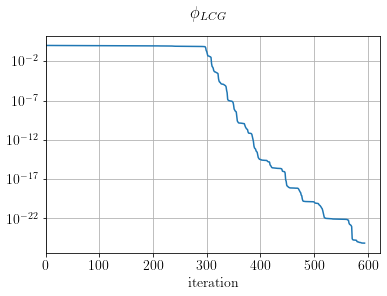

In [9]:
fig, ax = plt.subplots()
ax.semilogy((LCGsolver.obj / LCGsolver.obj[0]))
ax.set_xlabel("iteration")
ax.set_xlim(0)
plt.suptitle(r"$\phi_{LCG}$")
plt.show()

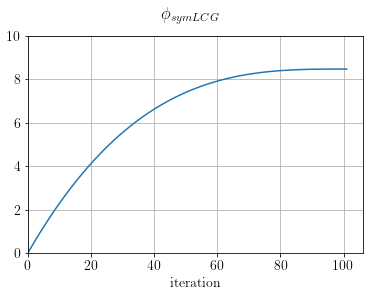

In [10]:
fig, ax = plt.subplots()
ax.plot(SLCG.obj)
ax.set_xlabel("iteration")
ax.set_xlim(0), ax.set_ylim(0,10)
plt.suptitle(r"$\phi_{symLCG}$")
plt.show()

Also, let's compare the two inverted functions with the analytical solution.
To find the solution for the continuous case we need three conditions:
\begin{equation}
\frac{d^2f(x)}{dx^2}=1,\\
f(x=0)=0,\\
f(x=x_f)=0.
\end{equation}
$x = 0$ and $x = x_f$ are not sampled and lay outside of the interval $\mathbf{x}$.

In [11]:
X = np.linspace(dx, N*dx, N)
alpha = 0.5
beta  = -(X[-1] + dx) * 0.5
gamma = 0.0
f_an  = alpha * X * X + beta * X + gamma

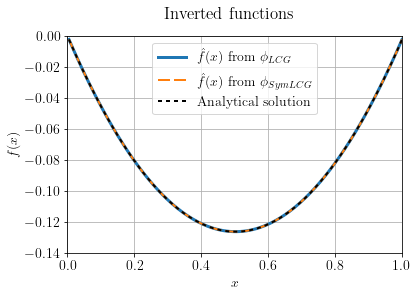

In [12]:
fig, ax = plt.subplots()

ax.plot(X, Phi1.model.plot(), linewidth=3, label="$\hat{f}(x)$ from $\phi_{LCG}$")
ax.plot(X, Phi2.model.plot(), linewidth=2, dashes=[6, 2], label="$\hat{f}(x)$ from $\phi_{SymLCG}$")
ax.plot(X, f_an, 'k', linewidth=2, dashes=[2, 2], label="Analytical solution")

ax.legend()
ax.set_xlabel(r"$x$"), ax.set_ylabel("$f(x)$")
ax.set_ylim(-0.14, 0), ax.set_xlim(0,1)

plt.suptitle("Inverted functions")
plt.show()

Now, let's try to solve both inversions using the inverse of $D_2$ as a preconditioner

In [13]:
# P = [D_2]^-1
P = o.Matrix(o.VectorNumpy(np.linalg.inv(D2.matrix.getNdArray())), f, y)

Phi1Prec = o.LeastSquares(f.clone(), y, D2, prec=P * P)
Phi2Prec = o.LeastSquaresSymmetric(f.clone(), y, D2, prec=P)

In [14]:
LCGsolver.setDefaults() # Re-setting default solver values
SLCG.setDefaults() # Re-setting default solver values

In [15]:
LCGsolver.run(Phi1Prec, verbose=True)

##########################################################################################
				PRECONDITIONED LINEAR CONJUGATE GRADIENT SOLVER
	Restart folder: /tmp/restart_2022-04-16T18-30-06.704265/
	Modeling Operator:		Matrix
##########################################################################################

iter = 0000, obj = 1.00000e+02, rnorm = 1.41e+01, gnorm = 5.66e+04, feval = 2
iter = 0001, obj = 1.60713e-22, rnorm = 1.79e-11, gnorm = 2.33e-06, feval = 4
iter = 0002, obj = 3.45248e-46, rnorm = 2.63e-23, gnorm = 5.63e-19, feval = 6
Objective function didn't reduce, will terminate solver:
	obj_new = 3.45248e-46	obj_cur = 3.45248e-46
##########################################################################################
				PRECONDITIONED LINEAR CONJUGATE GRADIENT SOLVER end
##########################################################################################



In [16]:
SLCG.run(Phi2Prec, verbose=True)

##########################################################################################

iter = 0000, obj = 0.00000e+00, rnorm = 1.41e+01, feval = 1
iter = 0001, obj = 8.45875e+00, rnorm = 1.64e-11, feval = 3
Objective function variation not monotonic, will terminate solver:
	obj_old=0.00000e+00 obj_cur=8.45875e+00 obj_new=8.45875e+00
##########################################################################################
			PRECONDITIONED LINEAR CONJUGATE GRADIENT SOLVER FOR SYMMETRIC SYSTEM end
##########################################################################################



As expected, we converge to the global minimum in effectively one iteration.